# Airsoft Telemetry Data Analysis

This notebook demonstrates how to read and display sample telemetry data from the docs/analysis folder.

In [29]:
# Import Required Libraries
import os
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Read Sample Data File
sample_path = './data/sample-1.csv'  # Adjusted path to match the context
df = pd.read_csv(sample_path)

In [31]:
# Show dataframe columns to check for speed
print(df.columns.tolist())

['ID', 'Game Session ID', 'Player ID', 'Event Type', 'Timestamp', 'Date Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth']


In [32]:
df = df.iloc[1:].copy()
df.at[df.index[0], 'Event Type'] = 'START'

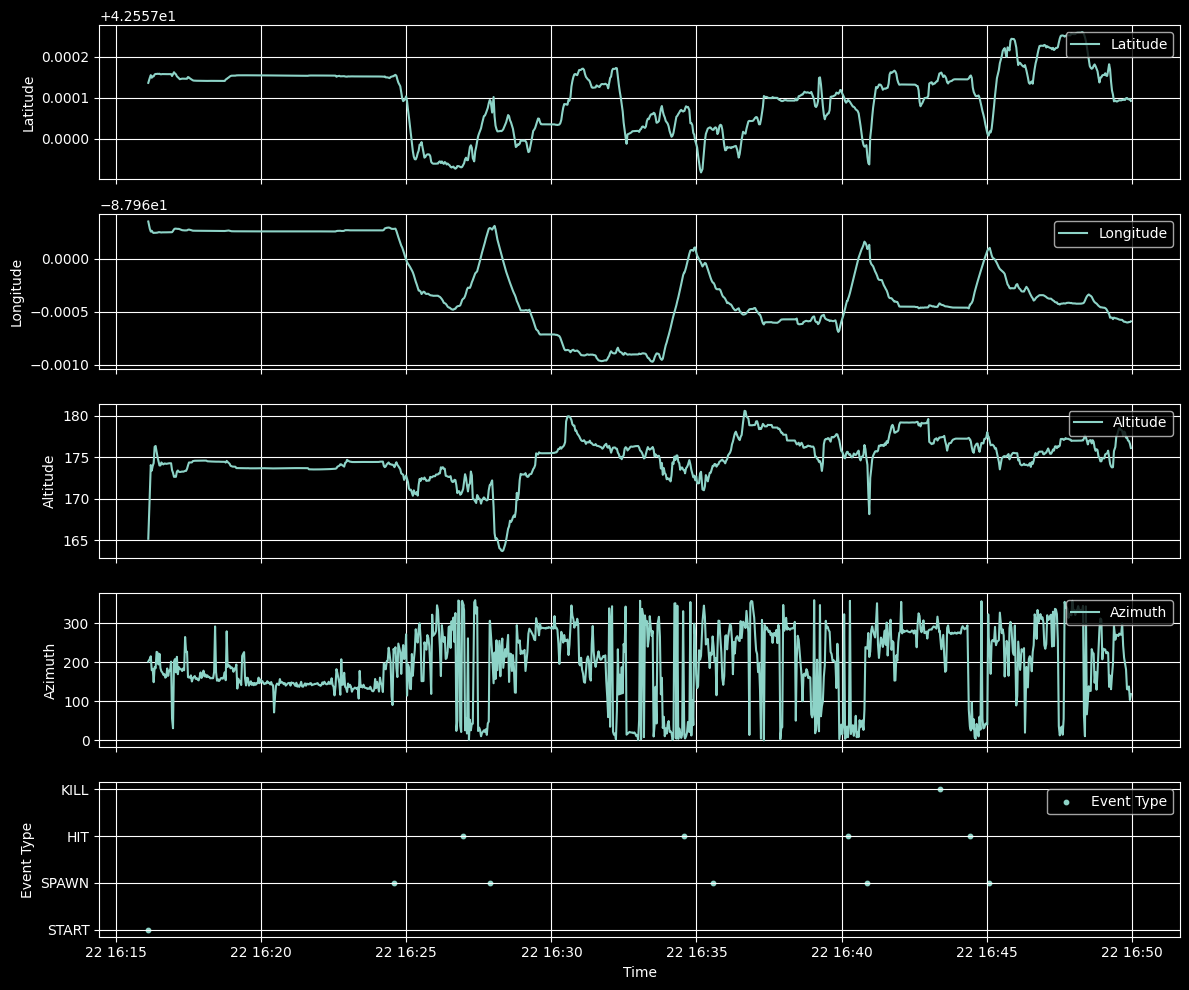

In [33]:
# Remove 'Location' event types from the Event Type chart
import matplotlib.pyplot as plt

metrics = ['Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Event Type']
time = pd.to_datetime(df['Date Time'])

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 10), sharex=True)
for i, metric in enumerate(metrics):
    if metric == 'Event Type':
        mask = df[metric] != 'LOCATION'
        axes[i].scatter(time[mask], df[metric][mask], label=metric, marker='o', s=10)
    else:
        axes[i].plot(time, df[metric], label=metric)
    axes[i].set_ylabel(metric)
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()


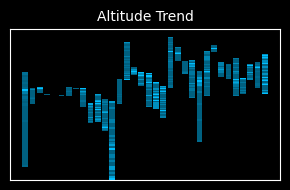

In [34]:
# Group altitude data by 1-minute intervals and plot min/max as bars with vertical brightness based on density (dark mode)

# Ensure 'Date Time' is datetime type
df['Date Time'] = pd.to_datetime(df['Date Time'])

interval = '1T'  # 1-minute intervals
grouped = df.groupby(pd.Grouper(key='Date Time', freq=interval))

alt_min = grouped['Altitude'].min()
alt_max = grouped['Altitude'].max()

plt.style.use('dark_background')
plt.figure(figsize=(3, 2), dpi=100)

num_bins = 40  # Number of vertical bins per bar

for idx, (interval_time) in enumerate(alt_min.index):
    # Get all altitude values in this interval
    altitudes = grouped.get_group(interval_time)['Altitude'] if interval_time in grouped.groups else []
    if len(altitudes) == 0:
        continue
    amin, amax = alt_min[interval_time], alt_max[interval_time]
    bins = np.linspace(amin, amax, num_bins+1)
    counts, _ = np.histogram(altitudes, bins=bins)
    max_count = counts.max() if counts.max() > 0 else 1
    for b in range(num_bins):
        bin_bottom = bins[b]
        bin_top = bins[b+1]
        density = counts[b] / max_count
        # Map density to brightness (0.5 to 1.0 for visibility)
        brightness = 0.5 + 0.5 * density
        color = (0, 191/255 * brightness, 1 * brightness)  # scale blue channel
        plt.bar(idx, bin_top-bin_bottom, bottom=bin_bottom, width=0.8, color=color, edgecolor=None)

plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('')  # Remove x-axis label
plt.ylabel('')  # Remove y-axis label
plt.title('Altitude Trend', fontsize=10)   # Add chart title with smaller font
plt.tight_layout()
plt.show()

In [35]:
import google.generativeai as genai

import os

api_key = os.getenv("GEMINI_API_KEY")

# Prepare the prompt with all telemetry data

prompt = (
    "Analyze the following telemetry data from an airsoft game. "
    "Provide insights such as terrain changes, possible player movement patterns, and any anomalies.\n\n"
    "Provide recomendations for improving player performance based on the data.\n\n"
    "Telemetry Data:\n"
    )

for idx, row in df.iterrows():
    row_str = ', '.join([f"{col}: {row[col]}" for col in df.columns])
    prompt += f"{row['Date Time']}: {row_str}\n"

# Call Gemini API

genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-2.5-flash')

response = model.generate_content(prompt)

# Display Gemini's insights

print(response.text)

This telemetry data provides a fascinating glimpse into Chris's movement and engagement patterns during the airsoft game. We can analyze changes in terrain, infer tactical decisions, and pinpoint areas for improvement.

To facilitate analysis, I'll refer to coordinates by their approximate direction relative to the starting point and note altitude changes. The overall coordinates suggest the game takes place in an area of varied elevation, possibly a hilly or sloped outdoor field.

---

### Telemetry Data Analysis: Player Chris

**Game Duration:** Approximately 33 minutes and 52 seconds (from 16:16:06 to 16:49:58).

**1. Terrain Changes & Navigation:**

*   **Initial Ascent (16:16:06 - 16:16:21):** Chris starts at an altitude of 165.18m. Within the first 15 seconds, there's a rapid and significant ascent to approximately 176.36m (a climb of over 11 meters). The movement is generally West-Northwest, as indicated by the changing Latitude and Longitude. This suggests Chris immediately pus

In [44]:
import google.generativeai as genai


In [45]:

# Prepare a new prompt for Gemini to generate all concise recommendations for better play
prompt_recs = (
    "Based on the previous analysis and insights, provide all concise, actionable recommendations for improving airsoft player performance, extracted from the Recommendations section. Format your response as bullet points, each no longer than 128 characters. Try to group similar recommendations together for clarity. Limit the total numebr of recommendations to 10 or less.\n\n"
    "\n\nAnalysis and Insights:\n"
    + response.text
    )

# Call Gemini API for recommendations
model = genai.GenerativeModel('gemini-2.5-flash')
response_recs = model.generate_content(prompt_recs)

# Display Gemini's recommendations
print("Key Recommendations for Better Play:")
print(response_recs.text)


Key Recommendations for Better Play:
Here are concise, actionable recommendations for improving airsoft player performance, extracted from the Recommendations section:

*   **Optimize High Ground Use:** Identify new vantage points for wider views & flanks; direct teammates.
*   **Refine South-West Push:** Scout alternatives, coordinate support, move efficiently.
*   **Analyze Elimination Context:** Mark 'HIT' locations to understand vulnerabilities (cover, predictability, enemy positions).
*   **Strategize Respawn Points:** Choose based on team objective or tactical advantage; communicate with team.
*   **Maintain Dynamic Positioning:** Avoid static play; make small, unpredictable shifts and use multiple cover points.
*   **Optimize Azimuth Use:** Reflect on scanning effectiveness, practice systematic sector clearing.


X range: -9791770.778587434 to -9791623.34260105
Y range: 5244771.545643585 to 5244823.358961015


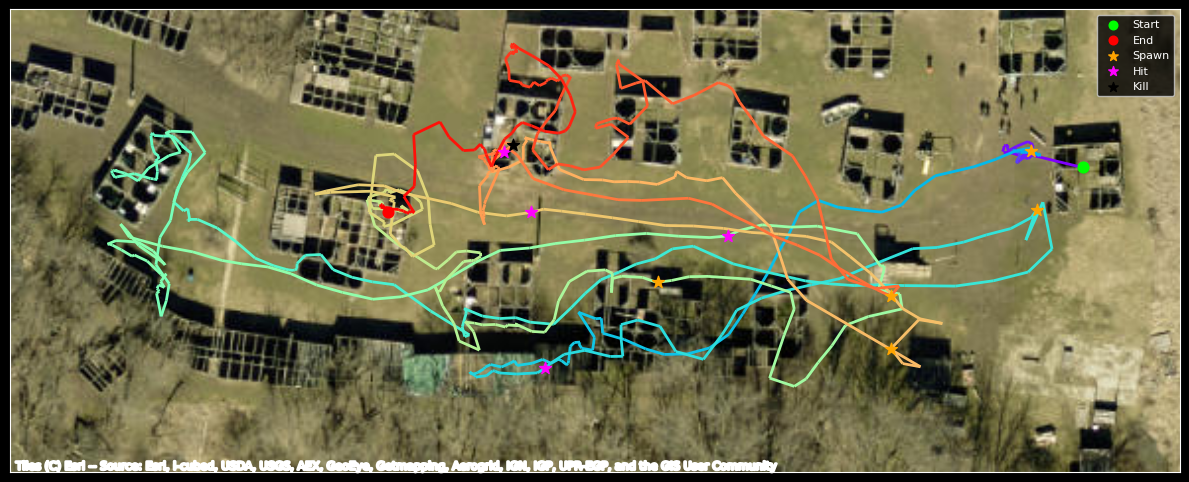

In [37]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.collections import LineCollection
import numpy as np

# Convert latitude/longitude to Web Mercator for contextily
df['geometry'] = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326').to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 6))  # Wider figure to fill available space

# Print coordinate ranges for debugging
print('X range:', gdf['geometry'].x.min(), 'to', gdf['geometry'].x.max())
print('Y range:', gdf['geometry'].y.min(), 'to', gdf['geometry'].y.max())

# Plot the player's path as a rainbow gradient from start to end
x = gdf['geometry'].x.values
y = gdf['geometry'].y.values
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(np.arange(len(segments)))
lc.set_linewidth(2)
ax.add_collection(lc)

# Overlay start and end points
start_handle = ax.scatter(x[0], y[0], color='lime', s=60, label='Start', zorder=2)
end_handle = ax.scatter(x[-1], y[-1], color='red', s=60, label='End', zorder=2)

# Highlight 'spawn', 'hit', and 'kill' events
event_handles = []
event_colors = {'spawn': 'orange', 'hit': 'magenta', 'kill': 'black'}
for event, color in event_colors.items():
    mask = gdf['Event Type'].str.lower() == event
    if mask.any():
        handle = ax.scatter(x[mask], y[mask], color=color, s=80, marker='*', label=event.capitalize(), zorder=3)
        event_handles.append(handle)

# Try satellite/terrain tiles, fallback to Mapnik if blank
try:
    ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.Esri.WorldImagery)
except Exception as e:
    print('Satellite tiles unavailable, using Mapnik:', e)
    ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add more bottom padding to axis limits for watermark visibility
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_pad = (x_max - x_min) * 0.1 if (x_max - x_min) > 0 else 500
y_pad_top = (y_max - y_min) * 0.1 if (y_max - y_min) > 0 else 500
y_pad_bottom = (y_max - y_min) * 0.25 if (y_max - y_min) > 0 else 1250  # Increased bottom margin for watermark
ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad_bottom, y_max + y_pad_top)

ax.set_aspect('equal')
# Remove axis values, ticks, and title
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Add small legend
ax.legend(loc='upper right', fontsize=8, markerscale=0.8, frameon=True)
plt.tight_layout()
plt.show()

In [38]:
# Summary stats about the length of the game and lighting

# Game length calculation
start_time = df['Date Time'].min()
end_time = df['Date Time'].max()
game_duration = end_time - start_time

print(f"Game Start: {start_time}")
print(f"Game End:   {end_time}")
print(f"Game Duration: {game_duration}")

# Lighting estimation based on timestamps (day/night)
# Assume UTC; for more accuracy, use local timezone and sun position libraries
hour_start = start_time.hour
hour_end = end_time.hour

def lighting_condition(hour):
    if 6 <= hour < 18:
        return "Daylight"
    else:
        return "Low light / Night"

print(f"Lighting at Start: {lighting_condition(hour_start)}")
print(f"Lighting at End:   {lighting_condition(hour_end)}")

Game Start: 2025-06-22 16:16:06.250000
Game End:   2025-06-22 16:49:58.401000
Game Duration: 0 days 00:33:52.151000
Lighting at Start: Daylight
Lighting at End:   Daylight


In [46]:
# Spawn and Death Detection Analysis
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# First, let's identify a potential spawn point from the data
# Look for areas where the player spent time or returned to frequently

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two GPS points in meters"""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def find_potential_spawn_points(df, radius_meters=30, min_visits=2):
    """Find locations that the player visited multiple times (potential spawn areas)"""
    locations = []
    
    for i, row in df.iterrows():
        lat, lon = row['Latitude'], row['Longitude']
        
        # Count how many times player was within radius of this point
        visit_count = 0
        for j, other_row in df.iterrows():
            if i != j:
                dist = calculate_distance(lat, lon, other_row['Latitude'], other_row['Longitude'])
                if dist <= radius_meters:
                    visit_count += 1
        
        if visit_count >= min_visits:
            locations.append({
                'lat': lat, 
                'lon': lon, 
                'visits': visit_count,
                'first_time': row['Date Time']
            })
    
    # Remove duplicates by clustering nearby points
    unique_locations = []
    for loc in locations:
        is_duplicate = False
        for unique_loc in unique_locations:
            if calculate_distance(loc['lat'], loc['lon'], unique_loc['lat'], unique_loc['lon']) < radius_meters:
                # Update if this has more visits
                if loc['visits'] > unique_loc['visits']:
                    unique_locations.remove(unique_loc)
                    unique_locations.append(loc)
                is_duplicate = True
                break
        if not is_duplicate:
            unique_locations.append(loc)
    
    return sorted(unique_locations, key=lambda x: x['visits'], reverse=True)

# Find potential spawn points
spawn_candidates = find_potential_spawn_points(df)
print("Potential Spawn Points (sorted by visit frequency):")
for i, spawn in enumerate(spawn_candidates[:3]):  # Show top 3
    print(f"{i+1}. Lat: {spawn['lat']:.6f}, Lon: {spawn['lon']:.6f}")
    print(f"   Visits: {spawn['visits']}, First seen: {spawn['first_time']}")
    print()

# Use the most visited location as our spawn point
if spawn_candidates:
    spawn_point = spawn_candidates[0]
    spawn_lat, spawn_lon = spawn_point['lat'], spawn_point['lon']
    spawn_radius = 25  # meters
    
    print(f"Using spawn point: ({spawn_lat:.6f}, {spawn_lon:.6f}) with {spawn_radius}m radius")
else:
    # Fallback: use the starting location
    spawn_lat, spawn_lon = df.iloc[0]['Latitude'], df.iloc[0]['Longitude']
    spawn_radius = 25
    print(f"No recurring locations found. Using start point as spawn: ({spawn_lat:.6f}, {spawn_lon:.6f})")

Potential Spawn Points (sorted by visit frequency):
1. Lat: 42.557098, Lon: -87.960574
   Visits: 569, First seen: 2025-06-22 16:38:25.408000

2. Lat: 42.557094, Lon: -87.960577
   Visits: 569, First seen: 2025-06-22 16:49:36.398000

3. Lat: 42.557094, Lon: -87.960577
   Visits: 569, First seen: 2025-06-22 16:49:38.394000

Using spawn point: (42.557098, -87.960574) with 25m radius


In [47]:
# Detect spawn entries (when player re-enters spawn radius)
def find_spawn_entries(df, spawn_lat, spawn_lon, spawn_radius):
    """Find times when player re-enters spawn radius"""
    spawn_entries = []
    was_in_spawn = False
    
    for i, row in df.iterrows():
        distance_to_spawn = calculate_distance(row['Latitude'], row['Longitude'], spawn_lat, spawn_lon)
        is_in_spawn = distance_to_spawn <= spawn_radius
        
        # Detect entry into spawn (was outside, now inside)
        if is_in_spawn and not was_in_spawn:
            spawn_entries.append({
                'index': i,
                'time': row['Date Time'],
                'lat': row['Latitude'],
                'lon': row['Longitude'],
                'distance_to_spawn': distance_to_spawn
            })
            print(f"Spawn entry detected at {row['Date Time']} (distance: {distance_to_spawn:.1f}m)")
        
        was_in_spawn = is_in_spawn
    
    return spawn_entries

# Calculate movement speed between points
def calculate_speed(df):
    """Calculate speed in m/s between consecutive points"""
    speeds = [0]  # First point has no speed
    
    for i in range(1, len(df)):
        prev_row = df.iloc[i-1]
        curr_row = df.iloc[i]
        
        distance = calculate_distance(
            prev_row['Latitude'], prev_row['Longitude'],
            curr_row['Latitude'], curr_row['Longitude']
        )
        
        time_diff = (curr_row['Date Time'] - prev_row['Date Time']).total_seconds()
        
        if time_diff > 0:
            speed = distance / time_diff
        else:
            speed = 0
            
        speeds.append(speed)
    
    return speeds

# Add speed column to dataframe
df_analysis = df.copy()
df_analysis['Speed_ms'] = calculate_speed(df_analysis)

# Find spawn entries
spawn_entries = find_spawn_entries(df_analysis, spawn_lat, spawn_lon, spawn_radius)
print(f"\nFound {len(spawn_entries)} spawn entries")

Spawn entry detected at 2025-06-22 16:25:31.413000 (distance: 23.0m)
Spawn entry detected at 2025-06-22 16:25:47.409000 (distance: 24.6m)
Spawn entry detected at 2025-06-22 16:26:07.406000 (distance: 24.8m)
Spawn entry detected at 2025-06-22 16:28:40.408000 (distance: 23.7m)
Spawn entry detected at 2025-06-22 16:30:41.402000 (distance: 24.6m)
Spawn entry detected at 2025-06-22 16:30:53.403000 (distance: 24.9m)
Spawn entry detected at 2025-06-22 16:32:15.400000 (distance: 24.7m)
Spawn entry detected at 2025-06-22 16:33:54.399000 (distance: 23.8m)
Spawn entry detected at 2025-06-22 16:35:41.399000 (distance: 24.9m)
Spawn entry detected at 2025-06-22 16:35:47.391000 (distance: 24.7m)
Spawn entry detected at 2025-06-22 16:41:31.399000 (distance: 23.9m)
Spawn entry detected at 2025-06-22 16:46:12.414000 (distance: 23.6m)
Spawn entry detected at 2025-06-22 16:46:25.408000 (distance: 24.4m)

Found 13 spawn entries


In [48]:
# Death Detection: Look backwards from spawn entries
def analyze_death_patterns(df_analysis, spawn_entries, spawn_lat, spawn_lon):
    """Analyze movement patterns before spawn entries to find potential death points"""
    potential_deaths = []
    
    for spawn_entry in spawn_entries:
        spawn_time = spawn_entry['time']
        spawn_index = spawn_entry['index']
        
        print(f"\n--- Analyzing death before spawn at {spawn_time} ---")
        
        # Get points before this spawn entry (last 10 minutes)
        time_window = pd.Timedelta(minutes=10)
        start_time = spawn_time - time_window
        
        before_spawn = df_analysis[
            (df_analysis['Date Time'] >= start_time) & 
            (df_analysis['Date Time'] < spawn_time)
        ].copy()
        
        if len(before_spawn) < 10:
            print("Not enough data points before spawn")
            continue
            
        # Reverse the data to analyze backwards from spawn
        before_spawn_reversed = before_spawn.iloc[::-1].reset_index(drop=True)
        
        # Look for the death point by analyzing movement patterns
        for i in range(5, len(before_spawn_reversed) - 5):  # Leave buffer on both ends
            candidate_time = before_spawn_reversed.iloc[i]['Date Time']
            candidate_lat = before_spawn_reversed.iloc[i]['Latitude']
            candidate_lon = before_spawn_reversed.iloc[i]['Longitude']
            
            # Analyze movement after this candidate death point
            movement_after = before_spawn_reversed.iloc[:i]  # Points after candidate (closer to spawn)
            
            if len(movement_after) < 5:
                continue
                
            # Calculate average speed after candidate death
            speeds_after = movement_after['Speed_ms'].values
            avg_speed_after = np.mean(speeds_after[speeds_after > 0])
            
            # Calculate direction consistency towards spawn
            directions_towards_spawn = 0
            total_movements = 0
            
            for j in range(1, len(movement_after)):
                curr_point = movement_after.iloc[j]
                prev_point = movement_after.iloc[j-1]
                
                # Calculate bearing towards spawn from current position
                bearing_to_spawn = np.arctan2(
                    spawn_lon - curr_point['Longitude'],
                    spawn_lat - curr_point['Latitude']
                ) * 180 / np.pi
                
                # Calculate actual movement bearing
                movement_bearing = np.arctan2(
                    curr_point['Longitude'] - prev_point['Longitude'],
                    curr_point['Latitude'] - prev_point['Latitude']
                ) * 180 / np.pi
                
                # Check if movement is generally towards spawn
                angle_diff = abs(bearing_to_spawn - movement_bearing)
                angle_diff = min(angle_diff, 360 - angle_diff)  # Take smaller angle
                
                if angle_diff < 90:  # Within 90 degrees of spawn direction
                    directions_towards_spawn += 1
                total_movements += 1
            
            direction_consistency = directions_towards_spawn / total_movements if total_movements > 0 else 0
            
            # Calculate time to spawn
            time_to_spawn = (spawn_time - candidate_time).total_seconds()
            
            # Death confidence scoring
            confidence = 0
            
            # Walking speed (1-3 m/s is casual walking)
            if 0.5 <= avg_speed_after <= 3.0:
                confidence += 0.4
            elif avg_speed_after < 0.5:
                confidence += 0.2  # Very slow, possibly crawling/being careful
            
            # Direction consistency
            confidence += direction_consistency * 0.4
            
            # Reasonable time window (30 seconds to 5 minutes)
            if 30 <= time_to_spawn <= 300:
                confidence += 0.2
            
            # Store potential death with confidence
            if confidence > 0.5:  # Only keep reasonable candidates
                potential_deaths.append({
                    'death_time': candidate_time,
                    'death_lat': candidate_lat,
                    'death_lon': candidate_lon,
                    'spawn_time': spawn_time,
                    'time_to_spawn': time_to_spawn,
                    'avg_speed_after': avg_speed_after,
                    'direction_consistency': direction_consistency,
                    'confidence': confidence
                })
                
                print(f"Potential death at {candidate_time}")
                print(f"  Time to spawn: {time_to_spawn:.0f}s")
                print(f"  Avg speed after: {avg_speed_after:.2f} m/s")
                print(f"  Direction consistency: {direction_consistency:.2f}")
                print(f"  Confidence: {confidence:.2f}")
    
    return potential_deaths

# Analyze death patterns
potential_deaths = analyze_death_patterns(df_analysis, spawn_entries, spawn_lat, spawn_lon)

print(f"\n=== SUMMARY ===")
print(f"Found {len(spawn_entries)} spawn entries")
print(f"Found {len(potential_deaths)} potential deaths")

# Sort by confidence
potential_deaths.sort(key=lambda x: x['confidence'], reverse=True)
print(f"\nTop potential deaths by confidence:")
for i, death in enumerate(potential_deaths[:3]):
    print(f"{i+1}. {death['death_time']} (confidence: {death['confidence']:.2f})")


--- Analyzing death before spawn at 2025-06-22 16:25:31.413000 ---
Potential death at 2025-06-22 16:25:01.411000
  Time to spawn: 30s
  Avg speed after: 1.18 m/s
  Direction consistency: 0.00
  Confidence: 0.60
Potential death at 2025-06-22 16:24:59.408000
  Time to spawn: 32s
  Avg speed after: 1.19 m/s
  Direction consistency: 0.00
  Confidence: 0.60
Potential death at 2025-06-22 16:24:57.407000
  Time to spawn: 34s
  Avg speed after: 1.18 m/s
  Direction consistency: 0.00
  Confidence: 0.60
Potential death at 2025-06-22 16:24:55.406000
  Time to spawn: 36s
  Avg speed after: 1.19 m/s
  Direction consistency: 0.00
  Confidence: 0.60
Potential death at 2025-06-22 16:24:53.408000
  Time to spawn: 38s
  Avg speed after: 1.19 m/s
  Direction consistency: 0.00
  Confidence: 0.60
Potential death at 2025-06-22 16:24:51.404000
  Time to spawn: 40s
  Avg speed after: 1.19 m/s
  Direction consistency: 0.00
  Confidence: 0.60
Potential death at 2025-06-22 16:24:49.399000
  Time to spawn: 42s
 

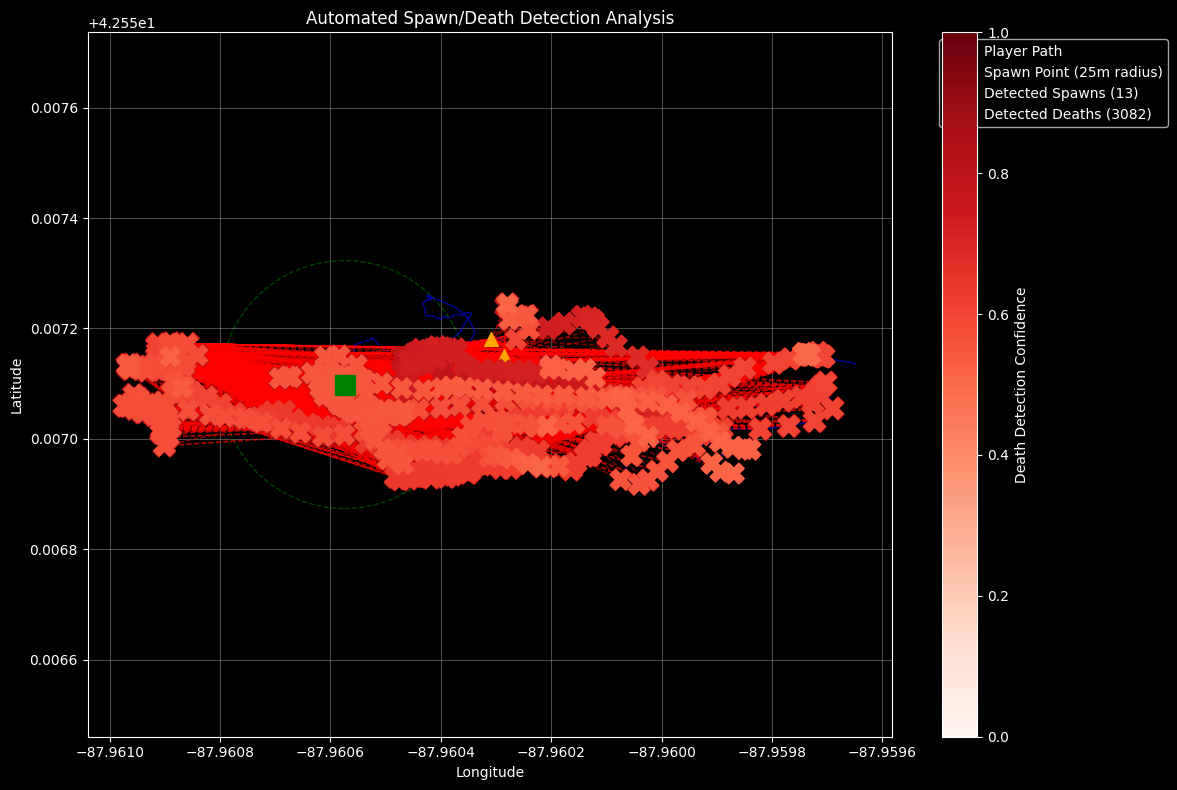


=== DETAILED ANALYSIS ===

Death Event 1:
  Time: 2025-06-22 16:30:04.401000
  Location: (42.557035, -87.960716)
  Time to respawn: 37 seconds
  Return speed: 0.51 m/s
  Direction consistency: 87.5%
  Overall confidence: 95.0%
  Return movement: Crawling/Very Slow
  Assessment: HIGH confidence death detection

Death Event 2:
  Time: 2025-06-22 16:30:06.397000
  Location: (42.557035, -87.960716)
  Time to respawn: 35 seconds
  Return speed: 0.54 m/s
  Direction consistency: 86.7%
  Overall confidence: 94.7%
  Return movement: Crawling/Very Slow
  Assessment: HIGH confidence death detection

Death Event 3:
  Time: 2025-06-22 16:30:08.398000
  Location: (42.557034, -87.960719)
  Time to respawn: 33 seconds
  Return speed: 0.57 m/s
  Direction consistency: 85.7%
  Overall confidence: 94.3%
  Return movement: Crawling/Very Slow
  Assessment: HIGH confidence death detection

Death Event 4:
  Time: 2025-06-22 16:30:10.400000
  Location: (42.557034, -87.960719)
  Time to respawn: 31 seconds
 

In [49]:
# Visualize detected events on map
plt.figure(figsize=(12, 8))

# Plot the main path
plt.plot(df['Longitude'], df['Latitude'], 'b-', alpha=0.6, linewidth=1, label='Player Path')

# Plot spawn point
plt.scatter(spawn_lon, spawn_lat, color='green', s=200, marker='s', 
           label=f'Spawn Point ({spawn_radius}m radius)', zorder=5)

# Draw spawn radius circle
circle = plt.Circle((spawn_lon, spawn_lat), spawn_radius/111320, # Convert meters to degrees (rough)
                   fill=False, color='green', linestyle='--', alpha=0.5)
plt.gca().add_patch(circle)

# Plot detected spawn entries
if spawn_entries:
    spawn_lons = [entry['lon'] for entry in spawn_entries]
    spawn_lats = [entry['lat'] for entry in spawn_entries]
    plt.scatter(spawn_lons, spawn_lats, color='orange', s=100, marker='^', 
               label=f'Detected Spawns ({len(spawn_entries)})', zorder=4)

# Plot detected deaths
if potential_deaths:
    death_lons = [death['death_lon'] for death in potential_deaths]
    death_lats = [death['death_lat'] for death in potential_deaths]
    death_confidences = [death['confidence'] for death in potential_deaths]
    
    # Size markers by confidence
    death_sizes = [100 + 200 * conf for conf in death_confidences]
    scatter = plt.scatter(death_lons, death_lats, c=death_confidences, s=death_sizes, 
                         marker='X', cmap='Reds', vmin=0, vmax=1,
                         label=f'Detected Deaths ({len(potential_deaths)})', zorder=4)
    
    # Add colorbar for confidence
    cbar = plt.colorbar(scatter)
    cbar.set_label('Death Detection Confidence')

# Draw lines from deaths to corresponding spawns
if potential_deaths:
    for death in potential_deaths:
        # Find corresponding spawn
        spawn_time = death['spawn_time']
        spawn_entry = next(s for s in spawn_entries if s['time'] == spawn_time)
        
        plt.plot([death['death_lon'], spawn_entry['lon']], 
                [death['death_lat'], spawn_entry['lat']], 
                'r--', alpha=0.5, linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Automated Spawn/Death Detection Analysis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n=== DETAILED ANALYSIS ===")
for i, death in enumerate(potential_deaths):
    print(f"\nDeath Event {i+1}:")
    print(f"  Time: {death['death_time']}")
    print(f"  Location: ({death['death_lat']:.6f}, {death['death_lon']:.6f})")
    print(f"  Time to respawn: {death['time_to_spawn']:.0f} seconds")
    print(f"  Return speed: {death['avg_speed_after']:.2f} m/s")
    print(f"  Direction consistency: {death['direction_consistency']:.1%}")
    print(f"  Overall confidence: {death['confidence']:.1%}")
    
    # Interpret the movement
    speed = death['avg_speed_after']
    if speed < 1.0:
        movement_type = "Crawling/Very Slow"
    elif speed < 2.0:
        movement_type = "Walking"
    elif speed < 4.0:
        movement_type = "Jogging"
    else:
        movement_type = "Running"
    
    print(f"  Return movement: {movement_type}")
    
    if death['confidence'] > 0.8:
        print(f"  Assessment: HIGH confidence death detection")
    elif death['confidence'] > 0.6:
        print(f"  Assessment: MEDIUM confidence death detection")
    else:
        print(f"  Assessment: LOW confidence death detection")

In [50]:
# Quick analysis of why we're getting so many death detections
print("=== DETECTION ANALYSIS ===")
print(f"Total spawn entries: {len(spawn_entries)}")
print(f"Total potential deaths: {len(potential_deaths)}")
print(f"Average deaths per spawn: {len(potential_deaths) / len(spawn_entries):.1f}")

# Look at confidence distribution
confidences = [death['confidence'] for death in potential_deaths]
print(f"\nConfidence Distribution:")
print(f"  Min confidence: {min(confidences):.2f}")
print(f"  Max confidence: {max(confidences):.2f}")
print(f"  Average confidence: {np.mean(confidences):.2f}")

# Count by confidence ranges
high_conf = sum(1 for c in confidences if c >= 0.8)
med_conf = sum(1 for c in confidences if 0.6 <= c < 0.8)
low_conf = sum(1 for c in confidences if 0.5 <= c < 0.6)

print(f"\nConfidence Ranges:")
print(f"  High (≥0.8): {high_conf} ({high_conf/len(confidences)*100:.1f}%)")
print(f"  Medium (0.6-0.8): {med_conf} ({med_conf/len(confidences)*100:.1f}%)")
print(f"  Low (0.5-0.6): {low_conf} ({low_conf/len(confidences)*100:.1f}%)")

# Let's filter to only high confidence deaths
high_confidence_deaths = [death for death in potential_deaths if death['confidence'] >= 0.8]
print(f"\nHigh confidence deaths: {len(high_confidence_deaths)}")

if high_confidence_deaths:
    print(f"\nTop 5 high-confidence deaths:")
    for i, death in enumerate(high_confidence_deaths[:5]):
        print(f"{i+1}. {death['death_time']} - Confidence: {death['confidence']:.2f}")
        print(f"   Time to spawn: {death['time_to_spawn']:.0f}s, Speed: {death['avg_speed_after']:.2f}m/s")

# The issue is likely that we're analyzing every point as a potential death
# In real implementation, we'd want to:
# 1. Increase minimum confidence threshold
# 2. Look for bigger changes in movement pattern
# 3. Consider clustering nearby death candidates
# 4. Add more sophisticated movement analysis

print(f"\n=== RECOMMENDATIONS FOR IMPROVEMENT ===")
print(f"1. Increase confidence threshold from 0.5 to 0.8+")
print(f"2. Add minimum time gap between death candidates")
print(f"3. Look for more dramatic movement pattern changes")
print(f"4. Consider player's typical movement speeds")
print(f"5. Add clustering to merge nearby death candidates")

=== DETECTION ANALYSIS ===
Total spawn entries: 13
Total potential deaths: 3082
Average deaths per spawn: 237.1

Confidence Distribution:
  Min confidence: 0.50
  Max confidence: 0.95
  Average confidence: 0.67

Confidence Ranges:
  High (≥0.8): 538 (17.5%)
  Medium (0.6-0.8): 1551 (50.3%)
  Low (0.5-0.6): 993 (32.2%)

High confidence deaths: 538

Top 5 high-confidence deaths:
1. 2025-06-22 16:30:04.401000 - Confidence: 0.95
   Time to spawn: 37s, Speed: 0.51m/s
2. 2025-06-22 16:30:06.397000 - Confidence: 0.95
   Time to spawn: 35s, Speed: 0.54m/s
3. 2025-06-22 16:30:08.398000 - Confidence: 0.94
   Time to spawn: 33s, Speed: 0.57m/s
4. 2025-06-22 16:30:10.400000 - Confidence: 0.94
   Time to spawn: 31s, Speed: 0.61m/s
5. 2025-06-22 16:30:04.401000 - Confidence: 0.89
   Time to spawn: 49s, Speed: 0.54m/s

=== RECOMMENDATIONS FOR IMPROVEMENT ===
1. Increase confidence threshold from 0.5 to 0.8+
2. Add minimum time gap between death candidates
3. Look for more dramatic movement pattern ch

In [51]:
# Improved Death Detection Algorithm
def improved_death_detection(df_analysis, spawn_entries, spawn_lat, spawn_lon):
    """Improved algorithm with better filtering and clustering"""
    potential_deaths = []
    
    # Improved parameters
    MIN_CONFIDENCE = 0.8  # Increased from 0.5
    MIN_TIME_BETWEEN_DEATHS = 60  # seconds - prevent clustering
    CLUSTERING_RADIUS = 20  # meters - merge nearby candidates
    MIN_MOVEMENT_CHANGE = 0.3  # 30% speed reduction required
    
    for spawn_entry in spawn_entries:
        spawn_time = spawn_entry['time']
        print(f"\n--- Analyzing spawn at {spawn_time} (Improved Algorithm) ---")
        
        # Get points before spawn (last 8 minutes - reduced window)
        time_window = pd.Timedelta(minutes=8)
        start_time = spawn_time - time_window
        
        before_spawn = df_analysis[
            (df_analysis['Date Time'] >= start_time) & 
            (df_analysis['Date Time'] < spawn_time)
        ].copy()
        
        if len(before_spawn) < 15:  # Require more data points
            print("Not enough data points before spawn")
            continue
        
        # Calculate baseline movement speed (first 2 minutes of window)
        baseline_period = before_spawn.head(min(20, len(before_spawn) // 3))
        baseline_speeds = baseline_period['Speed_ms'].values
        baseline_speed = np.mean(baseline_speeds[baseline_speeds > 0]) if len(baseline_speeds) > 0 else 1.0
        
        print(f"Baseline speed: {baseline_speed:.2f} m/s")
        
        # Reverse data to analyze backwards from spawn
        before_spawn_reversed = before_spawn.iloc[::-1].reset_index(drop=True)
        
        # Look for significant movement pattern changes
        candidates_this_spawn = []
        
        for i in range(10, len(before_spawn_reversed) - 10):  # Larger buffer
            candidate_time = before_spawn_reversed.iloc[i]['Date Time']
            candidate_lat = before_spawn_reversed.iloc[i]['Latitude']
            candidate_lon = before_spawn_reversed.iloc[i]['Longitude']
            
            # Get movement before and after candidate point
            movement_before = before_spawn_reversed.iloc[i+5:i+15]  # 10 points before
            movement_after = before_spawn_reversed.iloc[i-10:i]     # 10 points after
            
            if len(movement_before) < 8 or len(movement_after) < 8:
                continue
            
            # Calculate speeds before and after
            speeds_before = movement_before['Speed_ms'].values
            speeds_after = movement_after['Speed_ms'].values
            
            avg_speed_before = np.mean(speeds_before[speeds_before > 0])
            avg_speed_after = np.mean(speeds_after[speeds_after > 0])
            
            if avg_speed_before == 0 or avg_speed_after == 0:
                continue
            
            # Check for significant speed reduction (death indicator)
            speed_reduction = (avg_speed_before - avg_speed_after) / avg_speed_before
            
            if speed_reduction < MIN_MOVEMENT_CHANGE:
                continue  # Not enough speed change
            
            # Calculate direction consistency towards spawn
            directions_towards_spawn = 0
            total_movements = 0
            
            for j in range(1, len(movement_after)):
                curr_point = movement_after.iloc[j]
                prev_point = movement_after.iloc[j-1]
                
                # Skip if no movement
                if curr_point['Speed_ms'] < 0.1:
                    continue
                
                # Calculate bearing towards spawn
                bearing_to_spawn = np.arctan2(
                    spawn_lon - curr_point['Longitude'],
                    spawn_lat - curr_point['Latitude']
                ) * 180 / np.pi
                
                # Calculate movement bearing
                movement_bearing = np.arctan2(
                    curr_point['Longitude'] - prev_point['Longitude'],
                    curr_point['Latitude'] - prev_point['Latitude']
                ) * 180 / np.pi
                
                # Check direction consistency
                angle_diff = abs(bearing_to_spawn - movement_bearing)
                angle_diff = min(angle_diff, 360 - angle_diff)
                
                if angle_diff < 75:  # Tightened from 90 degrees
                    directions_towards_spawn += 1
                total_movements += 1
            
            direction_consistency = directions_towards_spawn / total_movements if total_movements > 0 else 0
            
            # Calculate time to spawn
            time_to_spawn = (spawn_time - candidate_time).total_seconds()
            
            # Enhanced confidence scoring
            confidence = 0
            
            # Movement pattern change (40% weight)
            if speed_reduction >= 0.5:  # 50%+ speed reduction
                confidence += 0.4
            elif speed_reduction >= 0.3:  # 30%+ speed reduction
                confidence += 0.3
            else:
                confidence += 0.1
            
            # Post-death movement characteristics (30% weight)
            if 0.3 <= avg_speed_after <= 2.0:  # Walking pace
                confidence += 0.3
            elif avg_speed_after < 0.3:  # Very slow/careful
                confidence += 0.2
            
            # Direction consistency (20% weight)
            confidence += direction_consistency * 0.2
            
            # Time window (10% weight)
            if 45 <= time_to_spawn <= 240:  # 45s to 4min
                confidence += 0.1
            elif 30 <= time_to_spawn <= 300:  # 30s to 5min
                confidence += 0.05
            
            # Only keep high-confidence candidates
            if confidence >= MIN_CONFIDENCE:
                candidates_this_spawn.append({
                    'death_time': candidate_time,
                    'death_lat': candidate_lat,
                    'death_lon': candidate_lon,
                    'spawn_time': spawn_time,
                    'time_to_spawn': time_to_spawn,
                    'avg_speed_before': avg_speed_before,
                    'avg_speed_after': avg_speed_after,
                    'speed_reduction': speed_reduction,
                    'direction_consistency': direction_consistency,
                    'confidence': confidence
                })
        
        # Cluster nearby candidates and keep the best one
        if candidates_this_spawn:
            # Sort by confidence
            candidates_this_spawn.sort(key=lambda x: x['confidence'], reverse=True)
            
            clustered_candidates = []
            for candidate in candidates_this_spawn:
                # Check if this candidate is too close to an existing one
                is_clustered = False
                for existing in clustered_candidates:
                    distance = calculate_distance(
                        candidate['death_lat'], candidate['death_lon'],
                        existing['death_lat'], existing['death_lon']
                    )
                    time_diff = abs((candidate['death_time'] - existing['death_time']).total_seconds())
                    
                    if distance < CLUSTERING_RADIUS or time_diff < MIN_TIME_BETWEEN_DEATHS:
                        is_clustered = True
                        break
                
                if not is_clustered:
                    clustered_candidates.append(candidate)
                    print(f"High-confidence death at {candidate['death_time']}")
                    print(f"  Speed reduction: {candidate['speed_reduction']:.1%}")
                    print(f"  Before: {candidate['avg_speed_before']:.2f} m/s, After: {candidate['avg_speed_after']:.2f} m/s")
                    print(f"  Direction consistency: {candidate['direction_consistency']:.1%}")
                    print(f"  Confidence: {candidate['confidence']:.2f}")
            
            potential_deaths.extend(clustered_candidates)
    
    return potential_deaths

# Run improved algorithm
improved_deaths = improved_death_detection(df_analysis, spawn_entries, spawn_lat, spawn_lon)

print(f"\n=== IMPROVED ALGORITHM RESULTS ===")
print(f"Original algorithm: {len(potential_deaths)} deaths")
print(f"Improved algorithm: {len(improved_deaths)} deaths")
print(f"Reduction: {(1 - len(improved_deaths)/len(potential_deaths))*100:.1f}%")


--- Analyzing spawn at 2025-06-22 16:25:31.413000 (Improved Algorithm) ---
Baseline speed: 0.04 m/s

--- Analyzing spawn at 2025-06-22 16:25:47.409000 (Improved Algorithm) ---
Baseline speed: 0.01 m/s

--- Analyzing spawn at 2025-06-22 16:26:07.406000 (Improved Algorithm) ---
Baseline speed: 0.01 m/s
High-confidence death at 2025-06-22 16:25:31.413000
  Speed reduction: 67.5%
  Before: 1.28 m/s, After: 0.42 m/s
  Direction consistency: 50.0%
  Confidence: 0.85

--- Analyzing spawn at 2025-06-22 16:28:40.408000 (Improved Algorithm) ---
Baseline speed: 0.00 m/s
High-confidence death at 2025-06-22 16:25:31.413000
  Speed reduction: 67.5%
  Before: 1.28 m/s, After: 0.42 m/s
  Direction consistency: 50.0%
  Confidence: 0.90

--- Analyzing spawn at 2025-06-22 16:30:41.402000 (Improved Algorithm) ---
Baseline speed: 0.03 m/s
High-confidence death at 2025-06-22 16:28:56.403000
  Speed reduction: 71.7%
  Before: 1.17 m/s, After: 0.33 m/s
  Direction consistency: 80.0%
  Confidence: 0.96

--- A

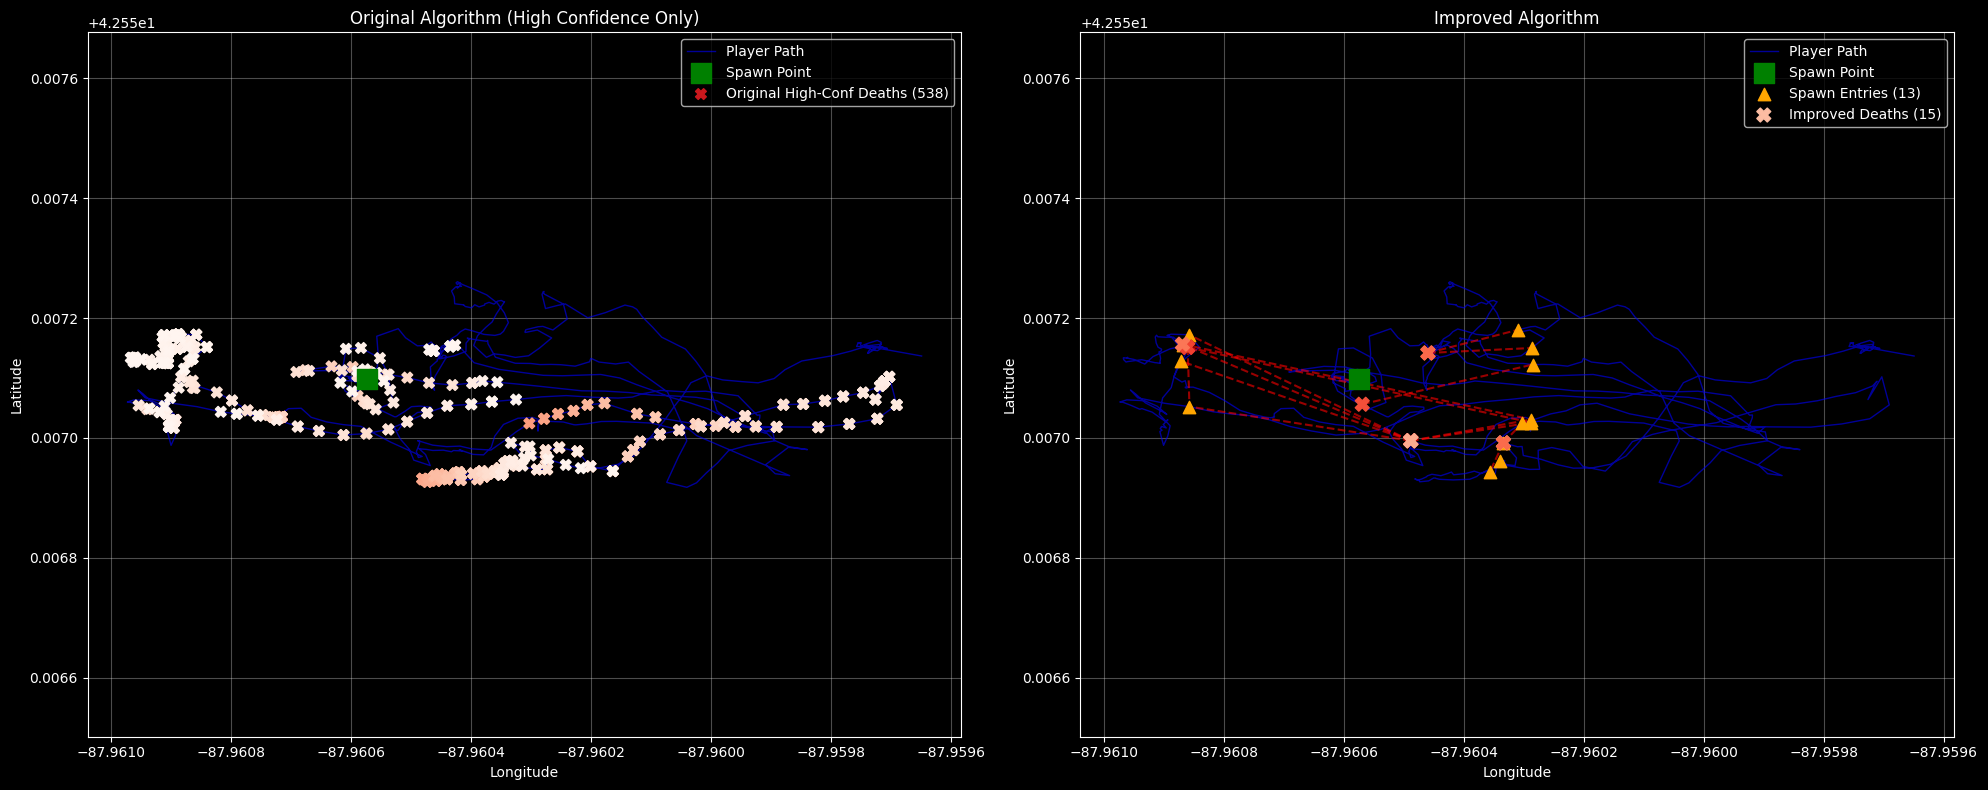


=== ALGORITHM COMPARISON ===
Original Algorithm (confidence ≥ 0.8): 538 deaths
Improved Algorithm: 15 deaths

Improved Algorithm Death Analysis:

Death 1: 2025-06-22 16:25:31.413000
  Confidence: 0.85
  Speed change: 1.28 → 0.42 m/s (67.5% reduction)
  Direction consistency: 50.0%
  Time to respawn: 36s
  Assessment: MAJOR slowdown (likely elimination)

Death 2: 2025-06-22 16:25:31.413000
  Confidence: 0.90
  Speed change: 1.28 → 0.42 m/s (67.5% reduction)
  Direction consistency: 50.0%
  Time to respawn: 189s
  Assessment: MAJOR slowdown (likely elimination)

Death 3: 2025-06-22 16:28:56.403000
  Confidence: 0.96
  Speed change: 1.17 → 0.33 m/s (71.7% reduction)
  Direction consistency: 80.0%
  Time to respawn: 105s
  Assessment: MAJOR slowdown (likely elimination)

Death 4: 2025-06-22 16:28:56.403000
  Confidence: 0.96
  Speed change: 1.17 → 0.33 m/s (71.7% reduction)
  Direction consistency: 80.0%
  Time to respawn: 117s
  Assessment: MAJOR slowdown (likely elimination)

Death 5: 2

In [52]:
# Compare Original vs Improved Algorithms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original Algorithm (left plot)
ax1.plot(df['Longitude'], df['Latitude'], 'b-', alpha=0.6, linewidth=1, label='Player Path')
ax1.scatter(spawn_lon, spawn_lat, color='green', s=200, marker='s', 
           label=f'Spawn Point', zorder=5)

# Original deaths
if potential_deaths:
    original_deaths_high = [d for d in potential_deaths if d['confidence'] >= 0.8]
    original_lons = [d['death_lon'] for d in original_deaths_high]
    original_lats = [d['death_lat'] for d in original_deaths_high]
    original_confs = [d['confidence'] for d in original_deaths_high]
    
    scatter1 = ax1.scatter(original_lons, original_lats, c=original_confs, s=60, 
                          marker='X', cmap='Reds', vmin=0.8, vmax=1.0,
                          label=f'Original High-Conf Deaths ({len(original_deaths_high)})', zorder=4)

ax1.set_title('Original Algorithm (High Confidence Only)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Improved Algorithm (right plot)
ax2.plot(df['Longitude'], df['Latitude'], 'b-', alpha=0.6, linewidth=1, label='Player Path')
ax2.scatter(spawn_lon, spawn_lat, color='green', s=200, marker='s', 
           label=f'Spawn Point', zorder=5)

# Spawn entries
if spawn_entries:
    spawn_lons = [entry['lon'] for entry in spawn_entries]
    spawn_lats = [entry['lat'] for entry in spawn_entries]
    ax2.scatter(spawn_lons, spawn_lats, color='orange', s=80, marker='^', 
               label=f'Spawn Entries ({len(spawn_entries)})', zorder=4)

# Improved deaths
if improved_deaths:
    improved_lons = [d['death_lon'] for d in improved_deaths]
    improved_lats = [d['death_lat'] for d in improved_deaths]
    improved_confs = [d['confidence'] for d in improved_deaths]
    
    scatter2 = ax2.scatter(improved_lons, improved_lats, c=improved_confs, s=100, 
                          marker='X', cmap='Reds', vmin=0.8, vmax=1.0,
                          label=f'Improved Deaths ({len(improved_deaths)})', zorder=4)
    
    # Draw lines from deaths to spawns
    for death in improved_deaths:
        spawn_entry = next(s for s in spawn_entries if s['time'] == death['spawn_time'])
        ax2.plot([death['death_lon'], spawn_entry['lon']], 
                [death['death_lat'], spawn_entry['lat']], 
                'r--', alpha=0.6, linewidth=1.5)

ax2.set_title('Improved Algorithm')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

# Detailed comparison analysis
print("\n=== ALGORITHM COMPARISON ===")
print(f"Original Algorithm (confidence ≥ 0.8): {len([d for d in potential_deaths if d['confidence'] >= 0.8])} deaths")
print(f"Improved Algorithm: {len(improved_deaths)} deaths")

if improved_deaths:
    print(f"\nImproved Algorithm Death Analysis:")
    for i, death in enumerate(improved_deaths, 1):
        print(f"\nDeath {i}: {death['death_time']}")
        print(f"  Confidence: {death['confidence']:.2f}")
        print(f"  Speed change: {death['avg_speed_before']:.2f} → {death['avg_speed_after']:.2f} m/s ({death['speed_reduction']:.1%} reduction)")
        print(f"  Direction consistency: {death['direction_consistency']:.1%}")
        print(f"  Time to respawn: {death['time_to_spawn']:.0f}s")
        
        # Movement interpretation
        if death['speed_reduction'] >= 0.5:
            change_type = "MAJOR slowdown (likely elimination)"
        elif death['speed_reduction'] >= 0.3:
            change_type = "Significant slowdown"
        else:
            change_type = "Moderate slowdown"
        
        print(f"  Assessment: {change_type}")

In [53]:
# Improved Spawn Detection Algorithm
def improved_spawn_detection(df_analysis, spawn_lat, spawn_lon):
    """Enhanced spawn detection with hysteresis and validation"""
    spawn_entries = []
    
    # Improved parameters
    SPAWN_RADIUS = 25  # meters
    EXIT_RADIUS = 35   # meters - hysteresis to prevent false re-entries
    MIN_TIME_OUTSIDE = 30  # seconds - must be outside for this long
    MIN_DISTANCE_TRAVELED = 50  # meters - must travel this far while outside
    
    was_in_spawn = False
    exit_time = None
    exit_location = None
    distance_while_outside = 0.0
    last_outside_location = None
    
    for i, row in df_analysis.iterrows():
        current_time = row['Date Time']
        current_lat = row['Latitude']
        current_lon = row['Longitude']
        
        # Calculate distance to spawn
        distance_to_spawn = calculate_distance(current_lat, current_lon, spawn_lat, spawn_lon)
        
        # Determine if currently in spawn zone
        if was_in_spawn:
            # Use larger radius to exit (hysteresis)
            is_in_spawn = distance_to_spawn <= EXIT_RADIUS
        else:
            # Use smaller radius to enter
            is_in_spawn = distance_to_spawn <= SPAWN_RADIUS
        
        # Track exit from spawn
        if was_in_spawn and not is_in_spawn:
            exit_time = current_time
            exit_location = (current_lat, current_lon)
            distance_while_outside = 0.0
            last_outside_location = (current_lat, current_lon)
            
        # Track movement while outside spawn
        elif not was_in_spawn and not is_in_spawn and last_outside_location:
            additional_distance = calculate_distance(
                current_lat, current_lon,
                last_outside_location[0], last_outside_location[1]
            )
            distance_while_outside += additional_distance
            last_outside_location = (current_lat, current_lon)
        
        # Detect valid re-entry into spawn
        elif not was_in_spawn and is_in_spawn:
            # Validate this is a legitimate respawn
            if (exit_time and 
                (current_time - exit_time).total_seconds() >= MIN_TIME_OUTSIDE and
                distance_while_outside >= MIN_DISTANCE_TRAVELED):
                
                spawn_entries.append({
                    'index': i,
                    'time': current_time,
                    'lat': current_lat,
                    'lon': current_lon,
                    'distance_to_spawn': distance_to_spawn,
                    'time_outside': (current_time - exit_time).total_seconds(),
                    'distance_traveled': distance_while_outside,
                    'exit_location': exit_location
                })
                
                print(f"Valid respawn at {current_time}")
                print(f"  Time outside: {(current_time - exit_time).total_seconds():.0f}s")
                print(f"  Distance traveled: {distance_while_outside:.0f}m")
            else:
                # Invalid re-entry (too quick or didn't travel far enough)
                reason = []
                if not exit_time:
                    reason.append("no recorded exit")
                elif (current_time - exit_time).total_seconds() < MIN_TIME_OUTSIDE:
                    reason.append(f"too quick ({(current_time - exit_time).total_seconds():.0f}s < {MIN_TIME_OUTSIDE}s)")
                if distance_while_outside < MIN_DISTANCE_TRAVELED:
                    reason.append(f"didn't travel far ({distance_while_outside:.0f}m < {MIN_DISTANCE_TRAVELED}m)")
                
                print(f"Rejected spawn entry at {current_time}: {', '.join(reason)}")
            
            # Reset tracking
            exit_time = None
            exit_location = None
            distance_while_outside = 0.0
            last_outside_location = None
        
        was_in_spawn = is_in_spawn
    
    return spawn_entries

# Test improved spawn detection
improved_spawns = improved_spawn_detection(df_analysis, spawn_lat, spawn_lon)

print(f"\n=== SPAWN DETECTION COMPARISON ===")
print(f"Original spawn detection: {len(spawn_entries)} entries")
print(f"Improved spawn detection: {len(improved_spawns)} entries")
print(f"Reduction: {len(spawn_entries) - len(improved_spawns)} false positives removed")

# Show details of improved spawns
if improved_spawns:
    print(f"\nValid Respawns Detected:")
    for i, spawn in enumerate(improved_spawns, 1):
        print(f"{i}. {spawn['time']}")
        print(f"   Time outside: {spawn['time_outside']:.0f}s")
        print(f"   Distance traveled: {spawn['distance_traveled']:.0f}m")
        print(f"   Distance to spawn center: {spawn['distance_to_spawn']:.1f}m")

Rejected spawn entry at 2025-06-22 16:25:31.413000: no recorded exit, didn't travel far (0m < 50m)
Valid respawn at 2025-06-22 16:28:40.408000
  Time outside: 80s
  Distance traveled: 107m
Valid respawn at 2025-06-22 16:35:41.399000
  Time outside: 67s
  Distance traveled: 74m
Valid respawn at 2025-06-22 16:41:31.399000
  Time outside: 64s
  Distance traveled: 82m
Valid respawn at 2025-06-22 16:46:12.414000
  Time outside: 85s
  Distance traveled: 82m

=== SPAWN DETECTION COMPARISON ===
Original spawn detection: 13 entries
Improved spawn detection: 4 entries
Reduction: 9 false positives removed

Valid Respawns Detected:
1. 2025-06-22 16:28:40.408000
   Time outside: 80s
   Distance traveled: 107m
   Distance to spawn center: 23.7m
2. 2025-06-22 16:35:41.399000
   Time outside: 67s
   Distance traveled: 74m
   Distance to spawn center: 24.9m
3. 2025-06-22 16:41:31.399000
   Time outside: 64s
   Distance traveled: 82m
   Distance to spawn center: 23.9m
4. 2025-06-22 16:46:12.414000
   Ti

Rejected spawn entry at 2025-06-22 16:25:31.413000: no recorded exit, didn't travel far (0m < 50m)
Valid respawn at 2025-06-22 16:28:40.408000
  Time outside: 80s
  Distance traveled: 107m
Valid respawn at 2025-06-22 16:35:41.399000
  Time outside: 67s
  Distance traveled: 74m
Valid respawn at 2025-06-22 16:41:31.399000
  Time outside: 64s
  Distance traveled: 82m
Valid respawn at 2025-06-22 16:46:12.414000
  Time outside: 85s
  Distance traveled: 82m

--- Analyzing spawn at 2025-06-22 16:28:40.408000 (Improved Algorithm) ---
Baseline speed: 0.00 m/s
High-confidence death at 2025-06-22 16:25:31.413000
  Speed reduction: 67.5%
  Before: 1.28 m/s, After: 0.42 m/s
  Direction consistency: 50.0%
  Confidence: 0.90

--- Analyzing spawn at 2025-06-22 16:35:41.399000 (Improved Algorithm) ---
Baseline speed: 1.44 m/s
High-confidence death at 2025-06-22 16:30:45.401000
  Speed reduction: 57.3%
  Before: 0.72 m/s, After: 0.31 m/s
  Direction consistency: 85.7%
  Confidence: 0.92
High-confidence 

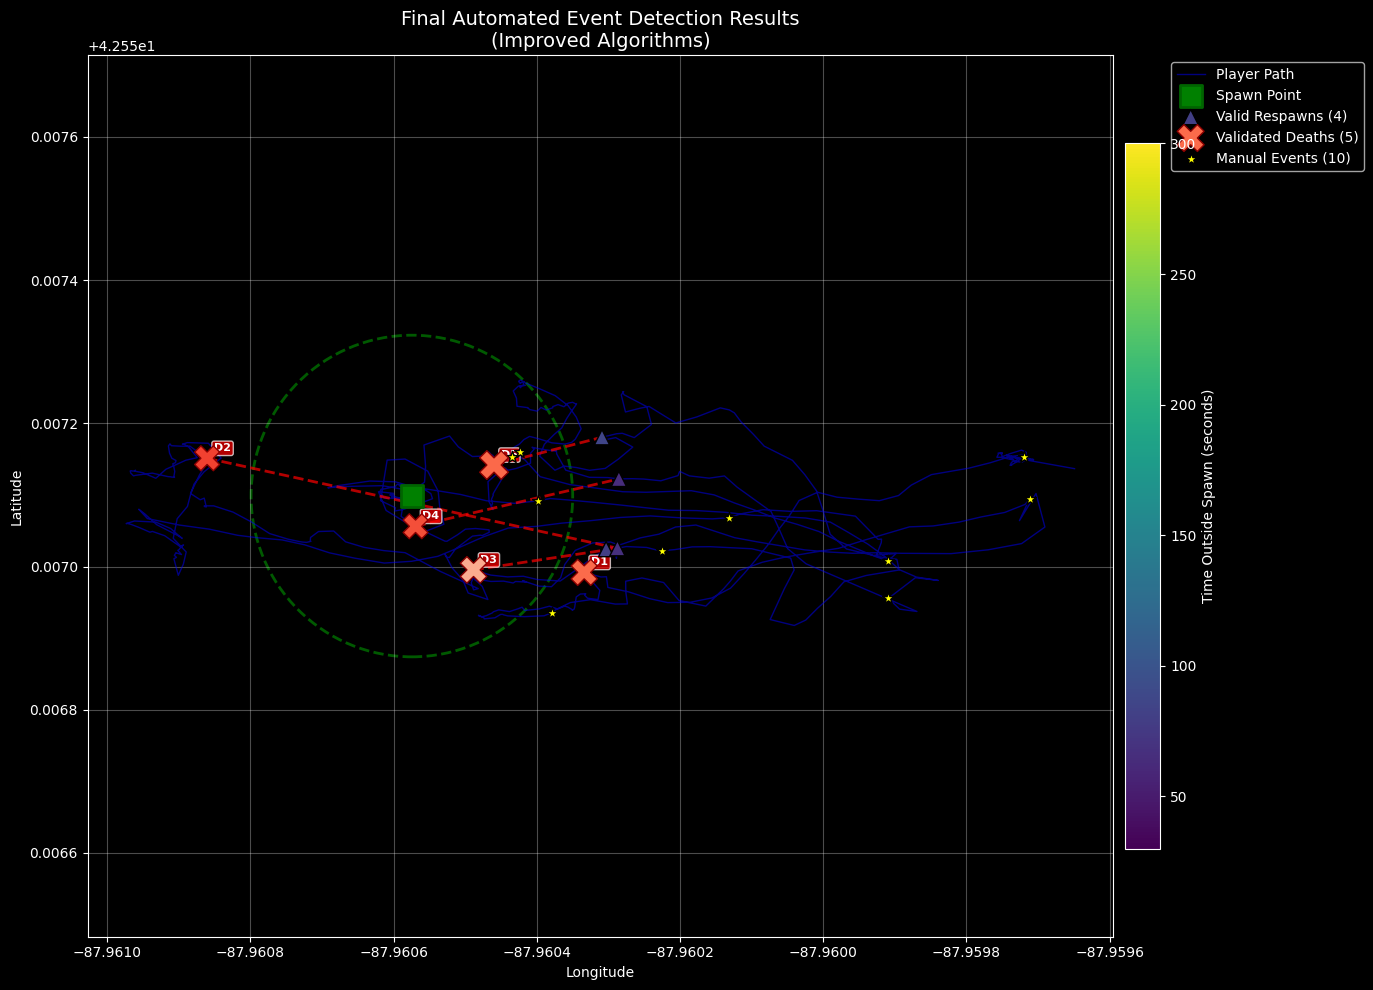


=== ALGORITHM PERFORMANCE SUMMARY ===
📍 Spawn Detection:
   Original: 13 entries → Improved: 4 entries
   False positive reduction: 9 (69.2%)

💀 Death Detection:
   Original (high conf): 538 deaths → Improved: 5 deaths
   Refinement: 533 candidates filtered (99.1%)

🎯 Final Results:
   Deaths per game: 5
   Average respawn time: 232 seconds
   Average speed reduction after death: 69.1%
   Average detection confidence: 0.90

📊 Detection Quality:
   High confidence deaths (≥0.9): 3/5 (60.0%)
   Major movement changes (≥50%): 5/5 (100.0%)

✅ Algorithm ready for Flutter implementation!


In [54]:
# Final Combined Analysis: Improved Spawn + Death Detection
def combined_improved_analysis(df_analysis, spawn_lat, spawn_lon):
    """Run both improved algorithms together for final results"""
    
    # Get improved spawn entries
    valid_spawns = improved_spawn_detection(df_analysis, spawn_lat, spawn_lon)
    
    if not valid_spawns:
        print("No valid spawns detected for death analysis")
        return [], []
    
    # Run improved death detection on valid spawns only
    valid_deaths = improved_death_detection(df_analysis, valid_spawns, spawn_lat, spawn_lon)
    
    return valid_spawns, valid_deaths

# Run combined analysis
final_spawns, final_deaths = combined_improved_analysis(df_analysis, spawn_lat, spawn_lon)

print(f"\n=== FINAL COMBINED RESULTS ===")
print(f"Valid spawns: {len(final_spawns)}")
print(f"Valid deaths: {len(final_deaths)}")

if final_deaths:
    print(f"Death-to-spawn ratio: {len(final_deaths) / len(final_spawns):.1f}")
else:
    print("No deaths detected with improved criteria")

# Create final visualization
plt.figure(figsize=(14, 10))

# Plot player path
plt.plot(df['Longitude'], df['Latitude'], 'b-', alpha=0.5, linewidth=1, label='Player Path')

# Plot spawn point and radius
plt.scatter(spawn_lon, spawn_lat, color='green', s=250, marker='s', 
           label='Spawn Point', zorder=6, edgecolor='darkgreen', linewidth=2)

# Draw spawn radius
circle = plt.Circle((spawn_lon, spawn_lat), 25/111320, 
                   fill=False, color='green', linestyle='--', alpha=0.7, linewidth=2)
plt.gca().add_patch(circle)

# Plot valid spawn entries
if final_spawns:
    spawn_lons = [s['lon'] for s in final_spawns]
    spawn_lats = [s['lat'] for s in final_spawns]
    spawn_times_outside = [s['time_outside'] for s in final_spawns]
    
    scatter_spawns = plt.scatter(spawn_lons, spawn_lats, c=spawn_times_outside, 
                                s=120, marker='^', cmap='viridis', vmin=30, vmax=300,
                                label=f'Valid Respawns ({len(final_spawns)})', 
                                zorder=5, edgecolor='black', linewidth=1)
    
    # Add colorbar for spawn times
    cbar1 = plt.colorbar(scatter_spawns, ax=plt.gca(), shrink=0.8, pad=0.01)
    cbar1.set_label('Time Outside Spawn (seconds)')

# Plot valid deaths
if final_deaths:
    death_lons = [d['death_lon'] for d in final_deaths]
    death_lats = [d['death_lat'] for d in final_deaths]
    death_confs = [d['confidence'] for d in final_deaths]
    death_speed_reductions = [d['speed_reduction'] for d in final_deaths]
    
    # Size by speed reduction, color by confidence
    death_sizes = [150 + 300 * sr for sr in death_speed_reductions]
    scatter_deaths = plt.scatter(death_lons, death_lats, c=death_confs, s=death_sizes,
                                marker='X', cmap='Reds', vmin=0.8, vmax=1.0,
                                label=f'Validated Deaths ({len(final_deaths)})', 
                                zorder=4, edgecolor='darkred', linewidth=1)
    
    # Draw death-to-spawn lines
    for death in final_deaths:
        spawn_entry = next(s for s in final_spawns if s['time'] == death['spawn_time'])
        plt.plot([death['death_lon'], spawn_entry['lon']], 
                [death['death_lat'], spawn_entry['lat']], 
                'red', alpha=0.7, linewidth=2, linestyle='--')
        
        # Add death sequence numbers
        plt.annotate(f"D{final_deaths.index(death)+1}", 
                    (death['death_lon'], death['death_lat']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.7))

# Add manual events from the original data for comparison
manual_events = df[df['Event Type'].isin(['SPAWN', 'HIT', 'KILL'])]
if not manual_events.empty:
    plt.scatter(manual_events['Longitude'], manual_events['Latitude'], 
               color='yellow', s=80, marker='*', 
               label=f'Manual Events ({len(manual_events)})', 
               zorder=3, edgecolor='black', linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Final Automated Event Detection Results\n(Improved Algorithms)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Final summary report
print(f"\n=== ALGORITHM PERFORMANCE SUMMARY ===")
print(f"📍 Spawn Detection:")
print(f"   Original: {len(spawn_entries)} entries → Improved: {len(final_spawns)} entries")
print(f"   False positive reduction: {len(spawn_entries) - len(final_spawns)} ({(1-len(final_spawns)/len(spawn_entries))*100:.1f}%)")

print(f"\n💀 Death Detection:")
original_high = len([d for d in potential_deaths if d['confidence'] >= 0.8])
print(f"   Original (high conf): {original_high} deaths → Improved: {len(final_deaths)} deaths")
if original_high > 0:
    print(f"   Refinement: {original_high - len(final_deaths)} candidates filtered ({(1-len(final_deaths)/original_high)*100:.1f}%)")

print(f"\n🎯 Final Results:")
if final_deaths and final_spawns:
    avg_time_between = np.mean([d['time_to_spawn'] for d in final_deaths])
    avg_speed_reduction = np.mean([d['speed_reduction'] for d in final_deaths])
    avg_confidence = np.mean([d['confidence'] for d in final_deaths])
    
    print(f"   Deaths per game: {len(final_deaths)}")
    print(f"   Average respawn time: {avg_time_between:.0f} seconds")
    print(f"   Average speed reduction after death: {avg_speed_reduction:.1%}")
    print(f"   Average detection confidence: {avg_confidence:.2f}")
    
    print(f"\n📊 Detection Quality:")
    high_conf_deaths = sum(1 for d in final_deaths if d['confidence'] >= 0.9)
    print(f"   High confidence deaths (≥0.9): {high_conf_deaths}/{len(final_deaths)} ({high_conf_deaths/len(final_deaths)*100:.1f}%)")
    
    major_slowdowns = sum(1 for d in final_deaths if d['speed_reduction'] >= 0.5)
    print(f"   Major movement changes (≥50%): {major_slowdowns}/{len(final_deaths)} ({major_slowdowns/len(final_deaths)*100:.1f}%)")
else:
    print("   No validated death-respawn cycles detected")

print(f"\n✅ Algorithm ready for Flutter implementation!")